In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda

# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

# Install wandb
#!pip install -q wandb
import wandb

# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [2]:
# Open csv file
corpus_path = "Macocu-sl-en-doc-format-filtered.csv"

corpus_df = pd.read_csv(corpus_path, sep = "\t", index_col= 0)

corpus_df.head(2)

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,average_score,en_doc,sl_doc,en_length,sl_length,punct_ratio
2584979,No,sl-orig,http://15.liffe.si/?lang_chg=en,B,B,http://15.liffe.si/?lang_chg=sl,15.liffe.si,15.liffe.si,0.936808,It went out with a bang. The evening sparkled ...,Končalo se je razburljivo in z razkošjem. Veče...,574,463,0.103501
1212933,No,sl-orig,http://16.liffe.si/?lang_chg=en,B,B,http://16.liffe.si/index.php?menu_item=domov,16.liffe.si,16.liffe.si,0.900000,Some days ago the organisers of the 17th Liffe...,Pred dnevi smo se iz 59. mednarodnega filmskeg...,293,184,0.076220


In [3]:
# See corpus size
corpus_df.shape

(101807, 14)

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# Initialize Wandb
run = wandb.init(project="X-GENRE classifiers", entity="tajak", name="testing-trained-model")

In [7]:
# Load the trained model from Wandb
model_name = "tajak/X-GENRE classifiers/X-GENRE-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", model_dir)

wandb: Downloading large artifact X-GENRE-classifier:latest, 1081.88MB. 8 files... Done. 0:0:0
/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [8]:
corpus_df.shape[0]

101807

In [20]:
output = model.predict(["hoj hej", "helo helo", "fzcj yiz"])

output

(['Forum', 'Forum', 'Forum'],
 array([[ 0.46240234, -1.42871094, -0.60058594, -1.08496094, -0.38623047,
          2.18359375, -0.42700195, -1.00195312,  1.59960938],
        [-0.05444336, -1.43457031, -0.65429688, -1.48046875, -0.25244141,
          5.75      , -0.34912109, -1.05566406, -0.71582031],
        [ 1.58886719, -1.82910156, -1.2890625 , -2.22070312, -0.25073242,
          3.46875   ,  2.30859375, -1.54882812, -0.54833984]]))

In [52]:
# Apply softmax to the raw outputs
def softmax(x):
#Compute softmax values for each sets of scores in x.
	return np.exp(x) / np.sum(np.exp(x), axis=0)

y_pred = []
y_distr = []
batch_counter = 0

for i in sample_batches:
	output = model.predict(i)
	current_y_pred = output[0]
	current_y_distr = output[1]
	current_y_distr_softmax = []
	for i in current_y_distr:
		distr = softmax(i)
		distr_sorted = np.sort(distr)
		current_y_distr_softmax.append(distr_sorted[-1])

	for i in current_y_pred:
		y_pred.append(i)
	
	for i in current_y_distr_softmax:
		y_distr.append(i)
	
	batch_counter += 1
	print(f"Batch {batch_counter} predicted.")
	
	json_backup = [batch_counter,y_pred, y_distr]

	# Save y_pred and y_distr just in case
	with open("batch-backup-predictions.json","w") as backup:
		json.dump(json_backup, backup)

print(y_pred)
print(y_distr)

(['Opinion/Argumentation', 'News', 'News'], array([[-1.29296875, -1.39453125,  2.24414062, -1.65234375,  6.8984375 ,
        -0.90429688, -1.2734375 , -2.13085938, -1.28027344],
       [-0.68164062, -2.03710938,  6.2421875 , -1.53710938,  2.92578125,
        -0.92724609, -0.92285156, -2.28320312, -2.04101562],
       [-1.53320312, -1.45507812,  7.3828125 , -1.09277344,  0.95214844,
        -1.11230469, -1.03222656, -1.85449219, -1.63378906]]))
Batch 1 predicted.
(['Opinion/Argumentation', 'News', 'Promotion'], array([[-0.81445312,  0.75439453, -0.57714844, -1.1796875 ,  7.47265625,
        -0.625     , -1.42773438, -1.69140625, -1.52734375],
       [-1.55761719, -1.24316406,  7.44140625, -1.0859375 ,  0.62109375,
        -1.26464844, -1.15234375, -1.79882812, -1.41308594],
       [-0.53613281,  3.55078125,  0.33105469, -0.62597656, -2.16796875,
        -2.70898438, -2.52539062,  1.16308594,  3.70898438]]))
Batch 2 predicted.
(['Legal', 'Legal', 'Information/Explanation'], array([[-0.95

In [ ]:
sample_batches = batches_list_new[:3]

sample_batches

In [58]:
def predict(dataframe, file_path):
    """
    This function takes the dataframe with English documents in the en_doc column, prepared in previous notebooks, and applies the trained model on it to infer predictions. It prints the time that it took to predict to all instances. It saves the results as a new column in the dataframe and returns the dataframe.

    Args:
    - dataframe (pandas DataFrame)
    - file_path: the path to the new CSV file with predictions
    """
    # Split the dataframe into batches
    # Create batches of text
    from itertools import islice

    def chunk(arr_range, arr_size):
        arr_range = iter(arr_range)
        return iter(lambda: tuple(islice(arr_range, arr_size)), ())

    batches_list = list(chunk(dataframe.en_doc, 3))

    batches_list_new = []

    for i in batches_list:
        batches_list_new.append(list(i))

    print(f"The dataset is split into {len(batches_list_new)} batches of {len(batches_list_new[0])} texts.")

    # Apply softmax to the raw outputs
    def softmax(x):
    #Compute softmax values for each sets of scores in x.
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    y_pred = []
    y_distr = []
    batch_counter = 0

    print("Prediction started.")
    start_time = time.time()

    for i in batches_list_new:
        output = model.predict(i)
        current_y_pred = output[0]
        current_y_distr = output[1]
        current_y_distr_softmax = []
        for i in current_y_distr:
            distr = softmax(i)
            distr_sorted = np.sort(distr)
            current_y_distr_softmax.append(distr_sorted[-1])

        for i in current_y_pred:
            y_pred.append(i)
        
        for i in current_y_distr_softmax:
            y_distr.append(i)
        
        batch_counter += 1
        print(f"Batch {batch_counter} predicted.")
        
        json_backup = [batch_counter,y_pred, y_distr]

        # Save y_pred and y_distr just in case
        with open("batch-backup-predictions.json","w") as backup:
            json.dump(json_backup, backup)

    prediction_time = round((time.time() - start_time)/60,2)

    print(f"Prediction completed. It took {prediction_time} minutes for {dataframe.shape[0]} instances - {prediction_time/dataframe.shape[0]} minutes per one instance.")
    
    dataframe["X-GENRE"] = y_pred
    dataframe["label_distribution"] = y_distr

    # Save the new dataframe which contains the y_pred values as well
    dataframe.to_csv(f"{file_path}", sep="\t")

    return dataframe

In [54]:
# Try the code on a sample of the corpus
sample_corpus = corpus_df.sample(n = 100)

sample_corpus.shape

(100, 14)

In [59]:
sample_predicted = predict(sample_corpus, "sample-corpus-filtered-predicted-test.csv") 

The dataset is split into 34 batches of 3 texts.
Prediction started.
Batch 1 predicted.
Batch 2 predicted.
Batch 3 predicted.
Batch 4 predicted.
Batch 5 predicted.
Batch 6 predicted.
Batch 7 predicted.
Batch 8 predicted.
Batch 9 predicted.
Batch 10 predicted.
Batch 11 predicted.
Batch 12 predicted.
Batch 13 predicted.
Batch 14 predicted.
Batch 15 predicted.
Batch 16 predicted.
Batch 17 predicted.
Batch 18 predicted.
Batch 19 predicted.
Batch 20 predicted.
Batch 21 predicted.
Batch 22 predicted.
Batch 23 predicted.
Batch 24 predicted.
Batch 25 predicted.
Batch 26 predicted.
Batch 27 predicted.
Batch 28 predicted.
Batch 29 predicted.
Batch 30 predicted.
Batch 31 predicted.
Batch 32 predicted.
Batch 33 predicted.
Batch 34 predicted.
Prediction completed. It took 0.59 minutes for 100 instances - 0.0059 minutes per one instance.


Prediction took 12 seconds per instance - it would take 350 hours (14 days) to predict everything. 

In [60]:
sample_predicted

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,average_score,en_doc,sl_doc,en_length,sl_length,punct_ratio,X-GENRE,label_distribution
2186273,No,sl-orig,https://cisotra.eu/,B,MIX,https://cisotra.eu/sl/o-projektu-cisotra/,cisotra.eu,cisotra.eu,0.915000,CiSoTRA Civil Society for social inclusion of ...,Naslov projekta: Civilna družba in socialno vk...,211,562,0.077236,Information/Explanation,0.995965
179779,No,sl-orig,http://psiholoska-obzorja.si/en/article?id=392,A,MIX,http://psiholoska-obzorja.si/article?id=392,psiholoska-obzorja.si,psiholoska-obzorja.si,0.963875,"We can distinguish healthy narcissism, an appr...","Povzetek: Ločimo zdrav narcisizem, ki se kaže ...",204,203,0.110204,Information/Explanation,0.999019
1477797,No,sl-orig,https://oblacila.si/regard-regard-cevlji-derby...,A,MIX,https://oblacila.si/karrimor-karrimor-resolve-...,oblacila.si,oblacila.si,0.824000,"The shoes fit well to the shape of the foot, t...",Zgornji del je izdelan iz kakovostne razteglji...,84,42,0.127273,Promotion,0.998912
154445,No,sl-orig,https://www.ntf.uni-lj.si/ntf/en/notification/...,A,B,https://www.ntf.uni-lj.si/ogro/news/informativ...,ntf.uni-lj.si,ntf.uni-lj.si,0.855000,"Geotechnology Department of Geotechnology, Min...",Informativni dan za 2. in 3. stopnjo Informati...,208,107,0.174194,Information/Explanation,0.998925
291402,No,sl-orig,https://www.sng-ng.si/en/repertory/archive/per...,UNK,B,https://sng-ng.si/repertoar/arhiv/predstave/20...,sng-ng.si,sng-ng.si,0.846714,"When, in the middle of a night, a successful m...",Ko se sredi noči uspešnež z ženo in prijateljs...,195,156,0.085106,Opinion/Argumentation,0.998021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158339,No,sl-orig,https://ikss.zrc-sazu.si/en/programi-in-projek...,B,B,https://ikss.zrc-sazu.si/sl/programi-in-projek...,ikss.zrc-sazu.si,ikss.zrc-sazu.si,0.950333,The project theorises multicultural heritage a...,Projekt zasnuje koncept večkulturne dediščine ...,75,72,0.083333,Information/Explanation,0.998955
481526,No,sl-orig,https://www.uni-lj.si/academies_and_faculties/...,UNK,B,https://www.uni-lj.si/studij/clanice,uni-lj.si,uni-lj.si,0.933917,FACULTY OF COMPUTER AND INFORMATION SCIENCE Th...,Biotehniška fakulteta Temeljno poslanstvo Biot...,306,342,0.060241,Information/Explanation,0.992803
598950,No,sl-orig,https://www.fdv.uni-lj.si/en/study/departments...,B,MIX,https://www.fdv.uni-lj.si/studij/oddelki-in-ka...,fdv.uni-lj.si,fdv.uni-lj.si,0.967833,"The December meeting of the ""Open Data"" The fo...",Decembrsko srečanje »Open data« Že četrto leto...,117,91,0.073529,Promotion,0.821992
2848706,No,sl-orig,https://support.microsoft.com/en-us/topic/use-...,A,A,https://support.microsoft.com/sl-si/office/raz...,support.microsoft.com,support.microsoft.com,0.911510,Heading level 2: The name of the channel Headi...,"Enkrat pritisnite tipko TAB, da premaknete fok...",3038,3782,0.111234,Instruction,0.998689


In [125]:
sample_predicted.shape

(100, 18)

In [126]:
# Analyze label distribution
sample_predicted["X-GENRE"].value_counts(normalize=True)

Information/Explanation    0.37
Promotion                  0.35
Instruction                0.09
News                       0.07
Opinion/Argumentation      0.04
Forum                      0.04
Legal                      0.02
Other                      0.02
Name: X-GENRE, dtype: float64

In [127]:
# Analyze the softmax values
sample_predicted["label_distribution"].describe()

count    100.000000
mean       0.963065
std        0.105893
min        0.477552
25%        0.996548
50%        0.998755
75%        0.998971
max        0.999106
Name: label_distribution, dtype: float64

Most values are very high.

In [3]:
# Open the file with predictions which was manually analyses

analysed_df = pd.read_csv("sample-corpus-predicted.csv", sep="\t", index_col = 0)

analysed_df.head(3)

,biroamer_entities,translation_direction,en_source,en_var_doc,en_var_dom,sl_source,en_domain,sl_domain,same_domains,different_domains,average_score,en_doc,sl_doc,en_length,sl_length,output,X-GENRE,label_distribution,analysis,comments
1887229,Yes,sl-orig,https://www.europarl.europa.eu/doceo/document/...,B,B,https://www.europarl.europa.eu/doceo/document/...,europarl.europa.eu,europarl.europa.eu,yes,europarl.europa.eu europarl.europa.eu,0.838333,Implementation of EU requirements for exchange...,Varnostne razmere v Burkina Fasu Izjava podpre...,101,119,"(['News'], array([[-1.33398438, 2.00195312, ...",News,0.991544,Non-textual,"not suitable: samo naštevanje naslovov, mi bi ..."
799225,No,sl-orig,https://www.grafolit.si/en/about_us.html,UNK,B,https://www.grafolit.si/onas.html,grafolit.si,grafolit.si,yes,grafolit.si grafolit.si,0.926091,DEVELOPMENT AND SHORT HISTORY The company was ...,RAZVOJ IN KRATKA ZGODOVINA Podjetje je ustanov...,463,223,"(['Information/Explanation'], array([[-0.68066...",Information/Explanation,0.999070,Information/Explanation,NaN
1001538,No,sl-orig,https://oblacila.si/nike-nike-advance-polo-shi...,A,MIX,https://oblacila.si/craft-craft-fuseknit-light...,oblacila.si,oblacila.si,yes,oblacila.si oblacila.si,0.814500,Smooth T-shirt with a round neckline. Smooth T...,"Izdelana je iz 100% bombaža, ki zelo dobro dih...",188,63,"(['Promotion'], array([[-0.60498047, -0.895507...",Promotion,0.998907,Promotion,"besedilo v angleščini se ponavlja, mogoče neka..."


In [134]:
# Analyze distribution of manually assigned labels
analysed_df.analysis.value_counts()

Promotion                  36
Information/Explanation    31
Non-textual                13
Instruction                 9
Opinion/Argumentation       4
News                        3
Legal                       3
Other                       1
Name: analysis, dtype: int64

In [5]:
# Analyze the characteristics of non-textual texts that were not removed with additional processing
remaining_non_textual = [150635, 2754062, 84675]


for i in remaining_non_textual:
	print(analysed_df.loc[i].en_doc)
	print(analysed_df.loc[i].label_distribution)


Dejan Habicht - Zvočni film / Sound Movie (00:05:22) Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2007 The sound of an airplane over a forest. Dejan Habicht - Nevarni vzorci Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2006 Dangerous Patterns is an electronic book, which can be printed at home (557KB). Dejan Habicht - die Heißeste Nummer Subtitle: 12 dolgočasnih pesmi Production: Center in Galerija P74, 2004/06 die Heißeste Nummer / The Hottest Number is an e-book that one can print at home. Saša Spačal - 7K: new life form (00:10:13) Production: Saša Spačal, Muzej sodobne umetnosti Metelkova - MSUM+, 2016 The video conceptually reflects on 7K: new life form, an artwork by Saša Spačal.
0.9986470725751748
Instructions for use of QR Code for FOTO LADO d.o.o. Click here for further information. Instructions for use of QR Code for STROPNIK RADO s.p. Instructions for use of QR Code for STROPNIK RADO s.p. Instructions for use of QR Code for PETER KL

In [135]:
# Discard texts that are in reality non-textual from the analysis
analysed_cleaned = analysed_df[analysed_df["analysis"]!= "Non-textual"]
analysed_cleaned.shape

(87, 20)

In [143]:
# Define labels that are present in the sample
print(analysed_cleaned.analysis.unique())
print(analysed_cleaned["X-GENRE"].unique())


LABELS = ['Information/Explanation', 'Promotion', 'Opinion/Argumentation', 'News', 'Instruction', 'Legal', 'Forum', 'Other']

['Information/Explanation' 'Promotion' 'Opinion/Argumentation' 'News'
 'Instruction' 'Legal' 'Other']
['Information/Explanation' 'Promotion' 'Opinion/Argumentation' 'News'
 'Instruction' 'Legal' 'Forum' 'Other']


Macro f1: 0.663, Micro f1: 0.908


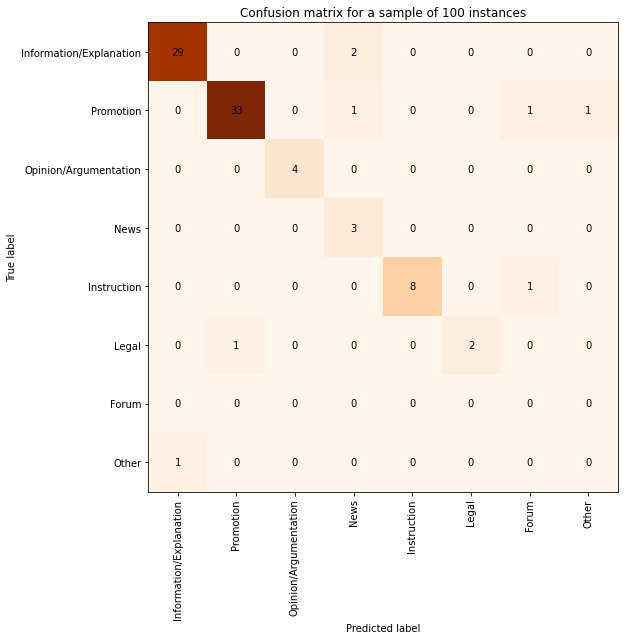

                         precision    recall  f1-score   support

Information/Explanation       0.97      0.94      0.95        31
              Promotion       0.97      0.92      0.94        36
  Opinion/Argumentation       1.00      1.00      1.00         4
                   News       0.50      1.00      0.67         3
            Instruction       1.00      0.89      0.94         9
                  Legal       1.00      0.67      0.80         3
                  Forum       0.00      0.00      0.00         0
                  Other       0.00      0.00      0.00         1

               accuracy                           0.91        87
              macro avg       0.68      0.68      0.66        87
           weighted avg       0.95      0.91      0.92        87



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

In [147]:
# Analyse results
y_true = analysed_cleaned["analysis"].to_list()
y_pred = analysed_cleaned["X-GENRE"].to_list()

# Calculate the scores
macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")

print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

# Plot the confusion matrix:
cm = confusion_matrix(y_true, y_pred, labels=LABELS)
plt.figure(figsize=(9, 9))
plt.imshow(cm, cmap="Oranges")
for (i, j), z in np.ndenumerate(cm):
	plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
classNames = LABELS
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=90)
plt.yticks(tick_marks, classNames)
plt.title(f"Confusion matrix for a sample of 100 instances")

plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
# Save the confusion matrix
fig1.savefig(f"Confusion-matrix-predicted-sample.png",dpi=100)

# Print classification report
print(classification_report(y_true, y_pred, labels = LABELS))